In [73]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.model_selection import KFold
from sklearn.kernel_approximation import Nystroem, RBFSampler


import scipy.stats
import scipy
import time

# Data generating process

In [74]:
# ground truth functions used
def true_fn_1(x):
  return x**2

def true_fn_2(x):
  return x**2 + 1

In [75]:
def generate_overlapping_groups(n, num_groups, random_noise = False):
    Xs = []
    ys = []

    np.random.seed(123)

    for i in range(num_groups):
        idx = i//2
        Xi = np.random.uniform(-1 + 4*idx/(num_groups), -1 + 4*(idx + 1)/(num_groups), size = (n, 1))
        if i%2 == 0:
          if random_noise == True:
            noise_val = np.random.uniform(1, 1.5)
          else:
            noise_val = 1
          yi = true_fn_1(Xi[:,0]) + np.random.normal(0, noise_val, size=n)
        else:
          if random_noise == True:
            noise_val = np.random.uniform(0, 0.1)
          else:
            noise_val = 0.1
          yi = true_fn_2(Xi[:,0]) + np.random.normal(0, 0.1, size=n)
        Xs.append(Xi)
        ys.append(yi)

    X = np.concatenate(Xs)
    y = np.concatenate(ys)
    groups = np.concatenate([np.array([i]*n) for i in range(num_groups)])
    return X, y, Xs, ys, groups


In [76]:
num_groups_same_size = [2, 10, 20, 30, 40, 50]
repeats_same_size = 100
group_size = 100

# data pull, all groups the same size
X_all_same_size = []
y_all_same_size = []
groups_all_same_size = []

for g in num_groups_same_size:
  X_all_same_size.append([])
  y_all_same_size.append([])
  groups_all_same_size.append([])
  for j in range(repeats_same_size):
    X, y, Xs, ys, groups = generate_overlapping_groups(group_size, g, random_noise = True)
    X_all_same_size[-1].append(X)
    y_all_same_size[-1].append(y)
    groups_all_same_size[-1].append(groups)

np.array(y_all_same_size).shape

<ipython-input-76-6a42850a500c>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(y_all_same_size).shape


(6, 100)

In [113]:
dataset_size = 2000
num_groups_ds = [2, 10, 20, 30, 40, 50]
X_all_ds = []
y_all_ds = []
groups_all_ds = []
repeats_ds = 100

for g in num_groups_ds:
  X_all_ds.append([])
  y_all_ds.append([])
  groups_all_ds.append([])
  for j in range(repeats_ds):
    X, y, Xs, ys, groups = generate_overlapping_groups(dataset_size//g, g, random_noise = True)
    X_all_ds[-1].append(X)
    y_all_ds[-1].append(y)
    groups_all_ds[-1].append(groups)

np.array(y_all_ds).shape

<ipython-input-113-29f9105317f5>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(y_all_ds).shape


(6, 100)

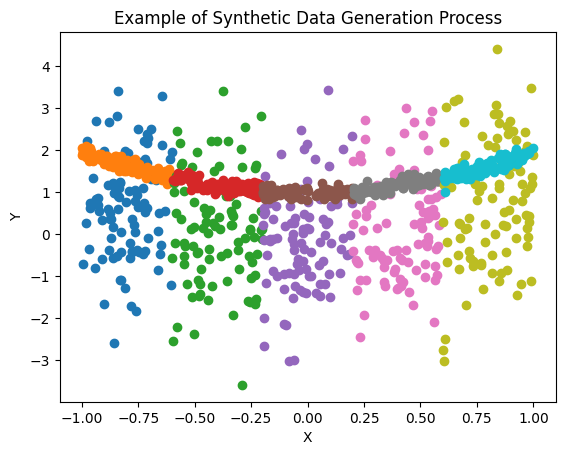

In [110]:
X, y, Xs, ys, groups = generate_overlapping_groups(100, 10, random_noise=True)
for i in range(10):
  plt.scatter(Xs[i], ys[i])

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Example of Synthetic Data Generation Process")
plt.savefig('example_data.pdf', dpi=300)


# Models

In [79]:
class Ensemble:
    def __init__(self, models):
        self.models = models
    def predict(self, X):
        return np.mean([mdl.predict(X) for mdl in self.models], axis=0)

## Adv Moments

In [80]:
class Adv_RKHS_Nystroem:

    def __init__(self, kernel='rbf', gamma=2, degree=3, coef0=1,
                 alpha=1, niters=10, kernel_params=None, n_components=100):
        """
        Parameters:
            kernel : a pairwise kernel function or a string; similar interface with KernelRidge in sklearn
            gamma : the gamma parameter for the kernel
            degree : the degree of a polynomial kernel
            coef0 : the zero coef for a polynomia kernel
            alpha : regularization strength (we will use lambda=alpha and mu=16*alpha)
            kernel_params : other kernel params passed to the kernel
            n_components : number of components for Nystroem approximation
        """
        self.kernel = kernel
        self.degree = degree
        self.coef0 = coef0
        self.gamma = gamma
        self.kernel_params = kernel_params
        self.alpha = alpha
        self.niters = niters

        self.nystroem = Nystroem(kernel=kernel,gamma= gamma, coef0=coef0, degree=self.degree,
                                 kernel_params=kernel_params, n_components=n_components)

    def best_response(self, weights, groups):
        nu, S = 0, 0

        ugroups = np.unique(groups)
        for it, g in enumerate(ugroups):
            _, nug, Sg = self.params[g]
            nu += weights[it] * nug
            S += weights[it] * Sg

        try:
            return scipy.linalg.solve(S, nu, assume_a="pos", overwrite_a=False)
        except:
            return scipy.linalg.lstsq(S, nu)[0]

    def fit(self, X, y, groups):
        alpha = self.alpha # regularization constant

        # Preprocessing
        Phi = self.nystroem.fit_transform(X)
        params = {}
        ugroups = np.unique(groups)
        for g in ugroups:
            Phig = Phi[groups==g]

            n = np.sum(groups==g)
            d = Phig.shape[1]

            Mg = np.linalg.inv(Phig.T @ Phig + n * alpha * np.eye(d))
            Qg = Phig @ Mg @ Phig.T

            kg = y[groups==g].T @ Qg @ y[groups==g].T
            nug = Phig.T @ Qg.T @ y[groups==g].T
            Sg = Phig.T @ Qg @ Phig + 4 * alpha * n * np.eye(d)

            params[g] = (kg, nug, Sg)

        self.params = params

        # No-regret dynamics
        T = self.niters
        eta = 1/np.sqrt(T)

        weights = np.ones(len(ugroups)) / len(ugroups)
        a = self.best_response(weights, groups)
        alphas = np.zeros((T, len(a)))
        alphas[0, :] = a

        for t in np.arange(1, T):
            for it, g in enumerate(ugroups):
                kg, nug, Sg = self.params[g]
                Ug = (1/n) * ( kg - 2 * nug.T @ alphas[t-1] + alphas[t-1].T @ Sg @ alphas[t-1] )
                weights[it] *= np.exp(eta * Ug)

            weights /= np.sum(weights)
            alphas[t] = self.best_response(weights, groups)

            #print(t, weights)

        self.a_adv = np.mean(alphas, axis=0)
        return self


    def predict(self, Xtest):
        return self.nystroem.transform(Xtest) @ self.a_adv

## groupDRO

In [34]:
class DRO_RKHS_Nystroem:

    def __init__(self, kernel='rbf', gamma=2, degree=3, coef0=1,
                 alpha=1, niters=10, kernel_params=None, n_components=100):
        """
        Parameters:
            kernel : a pairwise kernel function or a string; similar interface with KernelRidge in sklearn
            gamma : the gamma parameter for the kernel
            degree : the degree of a polynomial kernel
            coef0 : the zero coef for a polynomia kernel
            alpha : regularization strength (we will use lambda=alpha and mu=16*alpha)
            kernel_params : other kernel params passed to the kernel
            n_components : number of components for Nystroem approximation
        """
        self.kernel = kernel
        self.degree = degree
        self.coef0 = coef0
        self.gamma = gamma
        self.kernel_params = kernel_params
        self.alpha = alpha
        self.niters = niters

        self.nystroem = Nystroem(kernel=kernel,gamma= gamma, coef0=coef0, degree=self.degree,
                                 kernel_params=kernel_params, n_components=n_components)

    def fit(self, X, y, groups):
        Phi = self.nystroem.fit_transform(X)

        # No-regret dynamics
        T = self.niters
        eta = 1/np.sqrt(T)

        ugroups = np.unique(groups)
        weights = np.ones(len(ugroups)) / len(ugroups)
        models = []
        D = groups.astype('int')

        for t in np.arange(T):
            lr = Ridge(alpha=0.0001).fit(Phi, y, sample_weight=weights[groups])

            losses = np.zeros(len(ugroups))
            for it, g in enumerate(ugroups):
                losses[it] = np.mean((y[groups==g] - lr.predict(Phi[groups==g]))**2)

            weights *= np.exp(eta * np.array(losses))
            weights /= np.sum(weights)

            models.append(lr)


        self.ensemble = Ensemble(models)
        return self

    def predict(self, Xtest):
        return self.ensemble.predict(self.nystroem.transform(Xtest))



## MRO

In [35]:
class CDRO_RKHS_Nystroem:

    def __init__(self, kernel='rbf', gamma=2, degree=3, coef0=1,
                 alpha=1, niters=10, kernel_params=None, n_components=100):
        """
        Parameters:
            kernel : a pairwise kernel function or a string; similar interface with KernelRidge in sklearn
            gamma : the gamma parameter for the kernel
            degree : the degree of a polynomial kernel
            coef0 : the zero coef for a polynomia kernel
            alpha : regularization strength (we will use lambda=alpha and mu=16*alpha)
            kernel_params : other kernel params passed to the kernel
            n_components : number of components for Nystroem approximation
        """
        self.kernel = kernel
        self.degree = degree
        self.coef0 = coef0
        self.gamma = gamma
        self.kernel_params = kernel_params
        self.alpha = alpha
        self.niters = niters

        self.nystroem = Nystroem(kernel=kernel,gamma= gamma, coef0=coef0, degree=self.degree,
                                 kernel_params=kernel_params, n_components=n_components)

    def fit(self, X, y, groups):
        Phi = self.nystroem.fit_transform(X)

        # Perform ERM on each group
        closses = []
        ugroups = np.unique(groups)
        for g in ugroups:
            if self.nystroem != None:
                r = Ridge(alpha=0.01).fit(Phi[groups==g], y[groups==g])
                closs = np.mean((y[groups==g] - r.predict(Phi[groups==g]))**2)
                closses.append(closs)

        # No-regret dynamics
        T = self.niters
        eta = 1/np.sqrt(T)

        weights = np.ones(len(ugroups)) / len(ugroups)
        models = []
        D = groups.astype('int')

        for t in np.arange(T):
            lr = Ridge(alpha=0.0001).fit(Phi, y, sample_weight=weights[groups])

            losses = np.zeros(len(ugroups))
            for it, g in enumerate(ugroups):
                losses[it] = np.mean((y[groups==g] - lr.predict(Phi[groups==g]))**2) - closses[it]

            weights *= np.exp(eta * np.array(losses))
            weights /= np.sum(weights)

            models.append(lr)


        self.ensemble = Ensemble(models)
        return self

    def predict(self, Xtest):
        return self.ensemble.predict(self.nystroem.transform(Xtest))



# Comparison

In [114]:
moment_models_ds = []
dro_models_ds= []
cdro_models_ds = []

moment_times_ds = []
dro_times_ds = []
cdro_times_ds = []

for i in range(repeats_ds):
  print("repeat", i)
  for j in range(len(X_all_ds)):
    if i == 0:
      moment_times_ds.append([])
      dro_times_ds.append([])
      cdro_times_ds.append([])

    X = X_all_ds[j][i]
    y = y_all_ds[j][i]
    groups = groups_all_ds[j][i]

    init_time = time.process_time()
    adv_rkhs_lr = Adv_RKHS_Nystroem(kernel='rbf', n_components=100, alpha=0.0001, niters=5).fit(X, y, groups)
    moment_time = time.process_time() - init_time
    moment_times_ds[j].append(moment_time)
    if i == 0:
      moment_models_ds.append(adv_rkhs_lr)

    init_time = time.process_time()
    dro_rkhs_lr = DRO_RKHS_Nystroem(kernel='rbf', n_components=100, alpha=0.0001, niters=5).fit(X, y, groups)
    dro_time = time.process_time() - init_time
    dro_times_ds[j].append(dro_time)
    if i == 0:
      dro_models_ds.append(dro_rkhs_lr)

    init_time = time.process_time()
    cdro_rkhs_lr = CDRO_RKHS_Nystroem(kernel='rbf', n_components=100, alpha=0.0001, niters=5).fit(X, y, groups)
    cdro_time = time.process_time() - init_time
    cdro_times_ds[j].append(cdro_time)
    if i == 0:
      cdro_models_ds.append(cdro_rkhs_lr)

repeat 0
repeat 1
repeat 2
repeat 3
repeat 4
repeat 5
repeat 6
repeat 7
repeat 8
repeat 9
repeat 10
repeat 11
repeat 12
repeat 13
repeat 14
repeat 15
repeat 16
repeat 17
repeat 18
repeat 19
repeat 20
repeat 21
repeat 22
repeat 23
repeat 24
repeat 25
repeat 26
repeat 27
repeat 28
repeat 29
repeat 30
repeat 31
repeat 32
repeat 33
repeat 34
repeat 35
repeat 36
repeat 37
repeat 38
repeat 39
repeat 40
repeat 41
repeat 42
repeat 43
repeat 44
repeat 45
repeat 46
repeat 47
repeat 48
repeat 49
repeat 50
repeat 51
repeat 52
repeat 53
repeat 54
repeat 55
repeat 56
repeat 57
repeat 58
repeat 59
repeat 60
repeat 61
repeat 62
repeat 63
repeat 64
repeat 65
repeat 66
repeat 67
repeat 68
repeat 69
repeat 70
repeat 71
repeat 72
repeat 73
repeat 74
repeat 75
repeat 76
repeat 77
repeat 78
repeat 79
repeat 80
repeat 81
repeat 82
repeat 83
repeat 84
repeat 85
repeat 86
repeat 87
repeat 88
repeat 89
repeat 90
repeat 91
repeat 92
repeat 93
repeat 94
repeat 95
repeat 96
repeat 97
repeat 98
repeat 99


In [22]:
moment_models_same_size = []
dro_models_same_size= []
cdro_models_same_size = []

moment_times_ss = []
dro_times_ss = []
cdro_times_ss = []


for i in range(repeats_same_size):
  print("repeat", i)
  for j in range(len(X_all_same_size)):
    if i == 0:
      moment_times_ss.append([])
      dro_times_ss.append([])
      cdro_times_ss.append([])

    X = X_all_same_size[j][i]
    y = y_all_same_size[j][i]
    groups = groups_all_same_size[j][i]

    init_time = time.process_time()
    adv_rkhs_lr = Adv_RKHS_Nystroem(kernel='rbf', n_components=100, alpha=0.0001, niters=5).fit(X, y, groups)
    moment_time = time.process_time() - init_time
    moment_times_ss[j].append(moment_time)
    if i == 0:
      moment_models_same_size.append(adv_rkhs_lr)

    init_time = time.process_time()
    dro_rkhs_lr = DRO_RKHS_Nystroem(kernel='rbf', n_components=100, alpha=0.0001, niters=5).fit(X, y, groups)
    dro_time = time.process_time() - init_time
    dro_times_ss[j].append(dro_time)
    if i == 0:
      dro_models_same_size.append(dro_rkhs_lr)

    init_time = time.process_time()
    cdro_rkhs_lr = CDRO_RKHS_Nystroem(kernel='rbf', n_components=100, alpha=0.0001, niters=5).fit(X, y, groups)
    cdro_time = time.process_time() - init_time
    cdro_times_ss[j].append(cdro_time)
    if i == 0:
      cdro_models_same_size.append(cdro_rkhs_lr)



repeat 0
repeat 1
repeat 2
repeat 3
repeat 4
repeat 5
repeat 6
repeat 7
repeat 8
repeat 9
repeat 10
repeat 11
repeat 12
repeat 13
repeat 14
repeat 15
repeat 16
repeat 17
repeat 18
repeat 19
repeat 20
repeat 21
repeat 22
repeat 23
repeat 24
repeat 25
repeat 26
repeat 27
repeat 28
repeat 29
repeat 30
repeat 31
repeat 32
repeat 33
repeat 34
repeat 35
repeat 36
repeat 37
repeat 38
repeat 39
repeat 40
repeat 41
repeat 42
repeat 43
repeat 44
repeat 45
repeat 46
repeat 47
repeat 48
repeat 49
repeat 50
repeat 51
repeat 52
repeat 53
repeat 54
repeat 55
repeat 56
repeat 57
repeat 58
repeat 59
repeat 60
repeat 61
repeat 62
repeat 63
repeat 64
repeat 65
repeat 66
repeat 67
repeat 68
repeat 69
repeat 70
repeat 71
repeat 72
repeat 73
repeat 74
repeat 75
repeat 76
repeat 77
repeat 78
repeat 79
repeat 80
repeat 81
repeat 82
repeat 83
repeat 84
repeat 85
repeat 86
repeat 87
repeat 88
repeat 89
repeat 90
repeat 91
repeat 92
repeat 93
repeat 94
repeat 95
repeat 96
repeat 97
repeat 98
repeat 99


In [41]:
# save moment_times_ds to file
with open('moment_times_ss.npy', 'wb') as f:
    np.save(f, np.array(moment_times_ss))
with open('dro_times_ss.npy', 'wb') as f:
    np.save(f, np.array(dro_times_ss))
with open('cdro_times_ss.npy', 'wb') as f:
    np.save(f, np.array(cdro_times_ss))

with open('moment_times_ds.npy', 'wb') as f:
    np.save(f, np.array(moment_times_ss))
with open('dro_times_ds.npy', 'wb') as f:
    np.save(f, np.array(dro_times_ss))
with open('cdro_times_ds.npy', 'wb') as f:
    np.save(f, np.array(cdro_times_ss))

# Runtime Plots

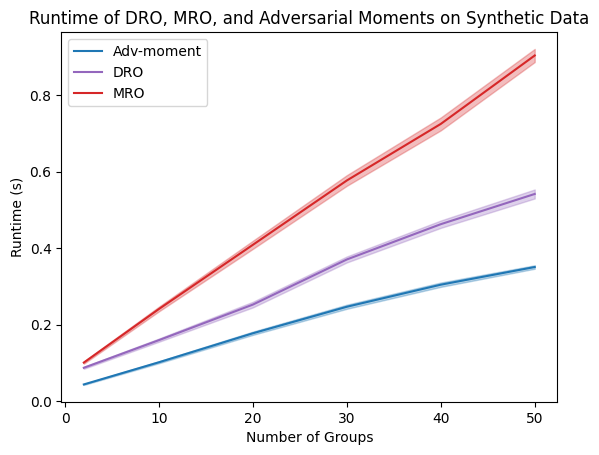

In [101]:
plt.plot(num_groups_same_size, np.mean(moment_times_ss, axis=1), color='C0', label='Adv-moment')
plt.fill_between(num_groups_same_size,
                 np.mean(moment_times_ss, axis=1) - np.std(moment_times_ss, axis=1)/np.sqrt(repeats_same_size),
                 np.mean(moment_times_ss, axis=1) + np.std(moment_times_ss, axis=1)/np.sqrt(repeats_same_size),
                 color='C0', alpha=0.3)

plt.plot(num_groups_same_size, np.mean(dro_times_ss, axis=1), color='C4', label='DRO')
plt.fill_between(num_groups_same_size,
                 np.mean(dro_times_ss, axis=1) - np.std(dro_times_ss, axis=1)/np.sqrt(repeats_same_size),
                 np.mean(dro_times_ss, axis=1) + np.std(dro_times_ss, axis=1)/np.sqrt(repeats_same_size),
                 color='C4', alpha=0.3)

plt.plot(num_groups_same_size, np.mean(cdro_times_ss, axis=1), color='C3', label='MRO')
plt.fill_between(num_groups_same_size,
                 np.mean(cdro_times_ss, axis=1) - np.std(cdro_times_ss, axis=1)/np.sqrt(repeats_same_size),
                 np.mean(cdro_times_ss, axis=1) + np.std(cdro_times_ss, axis=1)/np.sqrt(repeats_same_size),
                 color='C3', alpha=0.3)

plt.legend()
plt.title("Runtime of DRO, MRO, and Adversarial Moments on Synthetic Data")
plt.xlabel("Number of Groups")
plt.ylabel("Runtime (s)")
plt.savefig('rkhs_runtime.pdf', dpi=300)

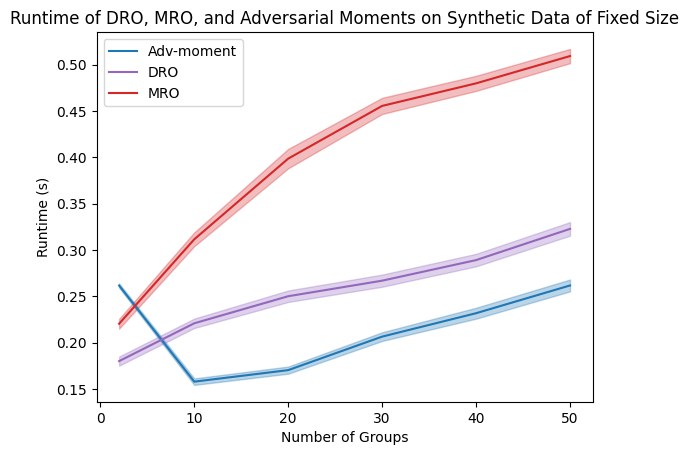

In [115]:
plt.plot(num_groups_ds, np.mean(moment_times_ds, axis=1), color='C0', label='Adv-moment')
plt.fill_between(num_groups_ds,
                 np.mean(moment_times_ds, axis=1) - np.std(moment_times_ds, axis=1)/np.sqrt(repeats_ds),
                 np.mean(moment_times_ds, axis=1) + np.std(moment_times_ds, axis=1)/np.sqrt(repeats_ds),
                 color='C0', alpha=0.3)

plt.plot(num_groups_ds, np.mean(dro_times_ds, axis=1), color='C4', label='DRO')
plt.fill_between(num_groups_ds,
                 np.mean(dro_times_ds, axis=1) - np.std(dro_times_ds, axis=1)/np.sqrt(repeats_ds),
                 np.mean(dro_times_ds, axis=1) + np.std(dro_times_ds, axis=1)/np.sqrt(repeats_ds),
                 color='C4', alpha=0.3)

plt.plot(num_groups_ds, np.mean(cdro_times_ds, axis=1), color='C3', label='MRO')
plt.fill_between(num_groups_ds,
                 np.mean(cdro_times_ds, axis=1) - np.std(cdro_times_ds, axis=1)/np.sqrt(repeats_ds),
                 np.mean(cdro_times_ds, axis=1) + np.std(cdro_times_ds, axis=1)/np.sqrt(repeats_ds),
                 color='C3', alpha=0.3)

plt.legend()
plt.title("Runtime of DRO, MRO, and Adversarial Moments on Synthetic Data of Fixed Size")
plt.xlabel("Number of Groups")
plt.ylabel("Runtime (s)")
plt.savefig('rkhs_runtime_fixed.pdf', dpi=300)


# Auditing for Regret Performance

In [116]:
def get_worst_l2(m):
  Xtest = np.linspace(-1, 1, 1000).reshape(-1, 1)
  loss1 = np.mean((true_fn_1(Xtest) - m.predict(Xtest))**2)
  loss2 = np.mean((true_fn_2(Xtest) - m.predict(Xtest))**2)
  return max(loss1, loss2)

moment_max_regret_ss = []
dro_max_regret_ss = []
cdro_max_regret_ss = []

for j in range(len(moment_models_same_size)):
  moment_max_regret_ss.append(get_worst_l2(moment_models_same_size[j]))
  dro_max_regret_ss.append(get_worst_l2(dro_models_same_size[j]))
  cdro_max_regret_ss.append(get_worst_l2(cdro_models_same_size[j]))

moment_max_regret_ds = []
dro_max_regret_ds = []
cdro_max_regret_ds = []

for j in range(len(moment_models_ds)):
  moment_max_regret_ds.append(get_worst_l2(moment_models_ds[j]))
  dro_max_regret_ds.append(get_worst_l2(dro_models_ds[j]))
  cdro_max_regret_ds.append(get_worst_l2(cdro_models_ds[j]))


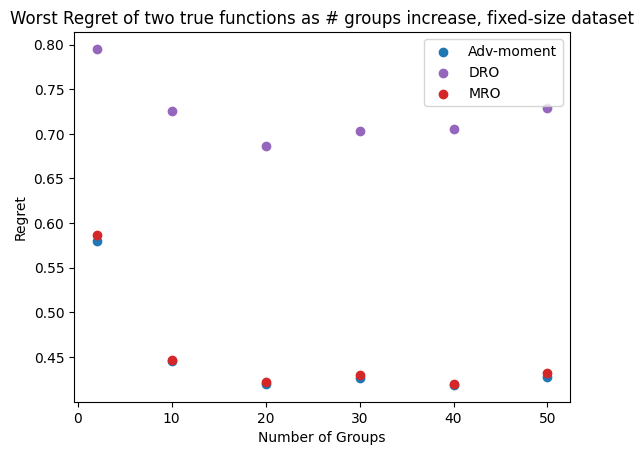

In [117]:
plt.scatter(num_groups_same_size, moment_max_regret_ss, label="Adv-moment", color="C0")
plt.scatter(num_groups_same_size, dro_max_regret_ss, label="DRO", color="C4")
plt.scatter(num_groups_same_size, cdro_max_regret_ss, label="MRO", color="C3")
plt.legend()
plt.xlabel("Number of Groups")
plt.ylabel("Regret")
plt.title("Worst Regret of two true functions as # groups increase, fixed-size dataset")
plt.savefig('worst_regret.pdf', dpi=300)

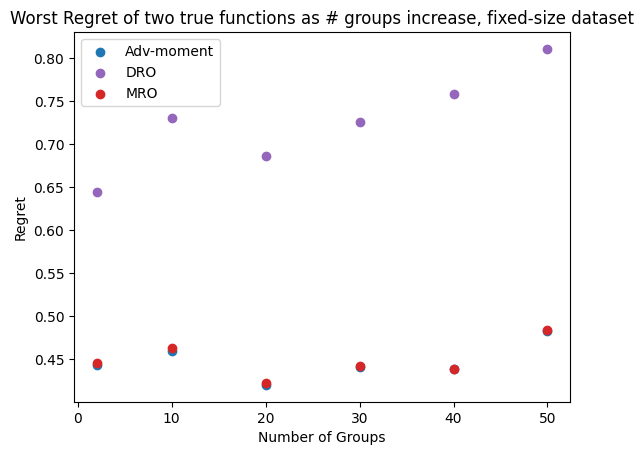

In [118]:
plt.scatter(num_groups_ds, moment_max_regret_ds, label="Adv-moment")
plt.scatter(num_groups_ds, dro_max_regret_ds, label="DRO", color="C4")
plt.scatter(num_groups_ds, cdro_max_regret_ds, label="MRO", color="C3")
plt.legend()
plt.xlabel("Number of Groups")
plt.ylabel("Regret")
plt.title("Worst Regret of two true functions as # groups increase, fixed-size dataset")
plt.savefig('worst_regret_fixed.pdf', dpi=300)

#Example Solution Plot

In [105]:
# plotting a run with 50 groups, each of size 100
X = X_all_same_size[5][0]
y = y_all_same_size[5][0]
groups = groups_all_same_size[5][0]


adv_rkhs_lr = Adv_RKHS_Nystroem(kernel='rbf', n_components=100, alpha=0.0001, niters=5).fit(X, y, groups)

dro_rkhs_lr = DRO_RKHS_Nystroem(kernel='rbf', n_components=100, alpha=0.0001, niters=5).fit(X, y, groups)

cdro_rkhs_lr = CDRO_RKHS_Nystroem(kernel='rbf', n_components=100, alpha=0.0001, niters=5).fit(X, y, groups)


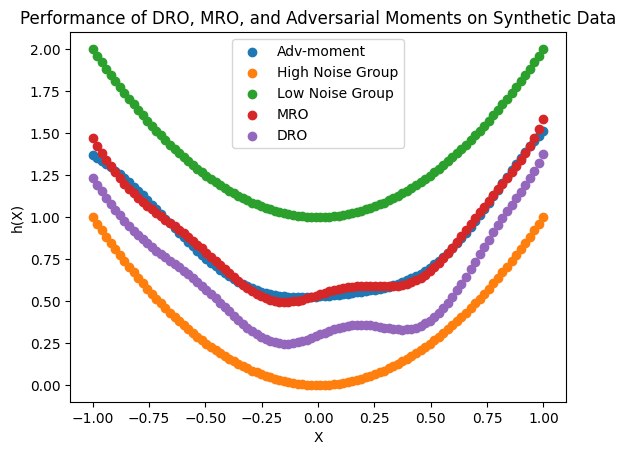

In [106]:
Xtest = np.linspace(-1, 1, 100).reshape(-1, 1)

plt.scatter(Xtest, adv_rkhs_lr.predict(Xtest), label='Adv-moment')
plt.scatter(Xtest, true_fn_1(Xtest), label='High Noise Group')
plt.scatter(Xtest, true_fn_2(Xtest), label='Low Noise Group')
plt.scatter(Xtest, cdro_rkhs_lr.predict(Xtest), label ='MRO')
plt.scatter(Xtest, dro_rkhs_lr.predict(Xtest), label='DRO')

plt.legend()
plt.title("Performance of DRO, MRO, and Adversarial Moments on Synthetic Data")
plt.xlabel("X")
plt.ylabel("h(X)")
plt.savefig('rkhs_performance.pdf', dpi=300)